In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn streamlit


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
df = pd.read_csv("data.csv", encoding="ISO-8859-1")
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
df = df.dropna(subset=["CustomerID"])
df = df[df["Quantity"] > 0]
df = df[df["UnitPrice"] > 0]


In [6]:
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])


In [7]:
total_revenue = df["TotalPrice"].sum()
print("Total Revenue:", total_revenue)


Total Revenue: 8911407.904


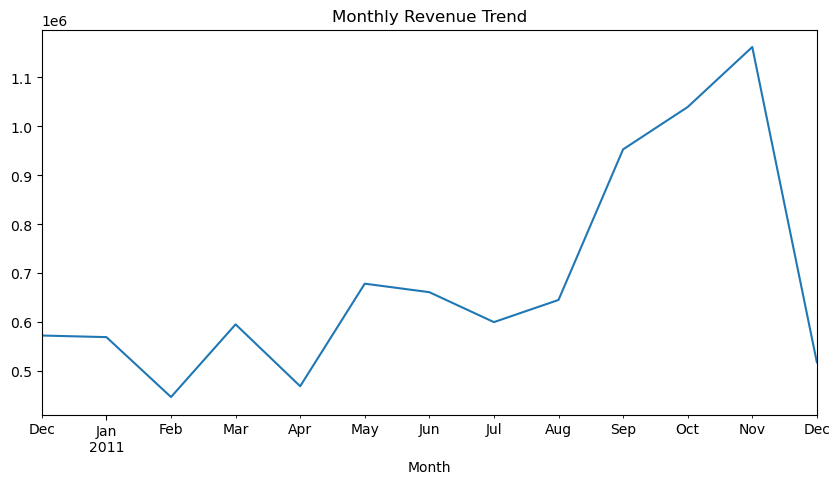

In [8]:
df["Month"] = df["InvoiceDate"].dt.to_period("M")

monthly_revenue = df.groupby("Month")["TotalPrice"].sum()

monthly_revenue.plot(figsize=(10,5))
plt.title("Monthly Revenue Trend")
plt.show()


In [18]:
latest_date = df["InvoiceDate"].max()

rfm_original = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (latest_date - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalPrice": "sum"
})

rfm_original.columns = ["Recency", "Frequency", "Monetary"]



In [19]:
rfm.corr()


,Recency,Frequency,Monetary,TotalQuantity,AvgUnitPrice
Recency,1.000000,-0.388799,-0.358008,-0.318024,0.014165
Frequency,-0.388799,1.000000,0.715856,0.580847,-0.021559
Monetary,-0.358008,0.715856,1.000000,0.819287,0.012142
TotalQuantity,-0.318024,0.580847,0.819287,1.000000,-0.038728
AvgUnitPrice,0.014165,-0.021559,0.012142,-0.038728,1.000000


<Axes: xlabel='Frequency', ylabel='Monetary'>

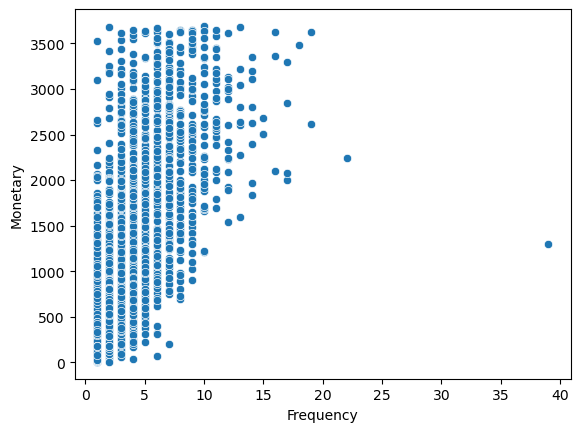

In [20]:
import seaborn as sns

sns.scatterplot(x="Frequency", y="Monetary", data=rfm)


<Axes: xlabel='Recency', ylabel='Monetary'>

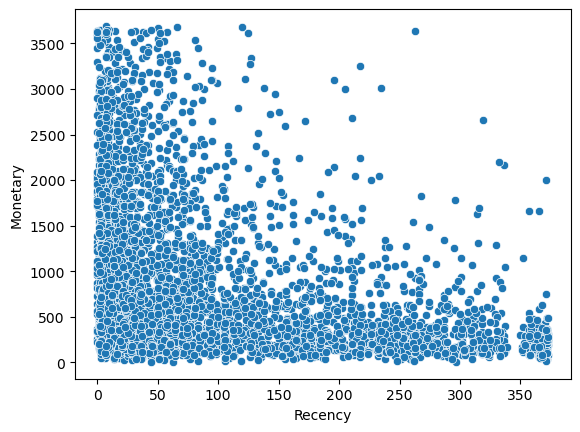

In [21]:
sns.scatterplot(x="Recency", y="Monetary", data=rfm)


In [22]:
rfm.describe()


,Recency,Frequency,Monetary,TotalQuantity,AvgUnitPrice
count,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000
mean,98.885707,2.909742,886.654537,540.000256,4.305533
std,101.581824,2.561726,828.537759,603.313762,34.633572
min,0.000000,1.000000,3.750000,1.000000,0.122500
25%,21.000000,1.000000,283.510000,146.000000,2.177280
50%,58.000000,2.000000,588.220000,322.000000,2.916000
75%,157.000000,4.000000,1246.210000,743.500000,3.850000
max,373.000000,39.000000,3692.280000,8000.000000,2033.100000


In [11]:
# Remove extreme Monetary outliers
Q1 = rfm["Monetary"].quantile(0.25)
Q3 = rfm["Monetary"].quantile(0.75)
IQR = Q3 - Q1

upper_limit = Q3 + 1.5 * IQR

rfm = rfm[rfm["Monetary"] <= upper_limit]


In [12]:
rfm.describe()


,Recency,Frequency,Monetary,TotalQuantity,AvgUnitPrice
count,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000
mean,98.885707,2.909742,886.654537,540.000256,4.305533
std,101.581824,2.561726,828.537759,603.313762,34.633572
min,0.000000,1.000000,3.750000,1.000000,0.122500
25%,21.000000,1.000000,283.510000,146.000000,2.177280
50%,58.000000,2.000000,588.220000,322.000000,2.916000
75%,157.000000,4.000000,1246.210000,743.500000,3.850000
max,373.000000,39.000000,3692.280000,8000.000000,2033.100000


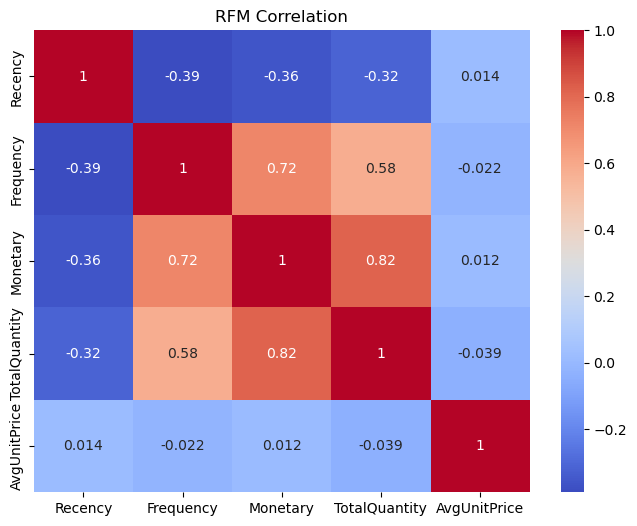

In [13]:
plt.figure(figsize=(8,6))
sns.heatmap(rfm.corr(), annot=True, cmap="coolwarm")
plt.title("RFM Correlation")
plt.show()


In [14]:
y = rfm["Monetary"]
X = rfm[["Recency", "Frequency", "TotalQuantity", "AvgUnitPrice"]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

pred = model.predict(X_test)

print("New R2:", r2_score(y_test, pred))


NameError: name 'StandardScaler' is not defined

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)


In [ ]:
pred = model.predict(X_test)

print("R2 Score:", r2_score(y_test, pred))


In [ ]:
import pickle
import numpy as np

model = pickle.load(open("model.pkl", "rb"))
scaler = pickle.load(open("scaler.pkl", "rb"))


In [ ]:
recency = 30          # days since last purchase
frequency = 5         # number of purchases
quantity = 100        # total quantity purchased
avg_price = 15        # average price per product


In [ ]:
input_data = np.array([[recency, frequency, quantity, avg_price]])


In [ ]:
print(input_data.shape)


In [ ]:
input_scaled = scaler.transform(input_data)


In [ ]:
sample = rfm.iloc[0]

recency = sample["Recency"]
frequency = sample["Frequency"]
quantity = sample["TotalQuantity"]
avg_price = sample["AvgUnitPrice"]

input_data = np.array([[recency, frequency, quantity, avg_price]])
input_scaled = scaler.transform(input_data)

prediction = model.predict(input_scaled)

print("Actual:", sample["Monetary"])
print("Predicted:", prediction[0])


In [ ]:
print(X.columns)


In [ ]:
print(sample)


In [ ]:
prediction = model.predict(input_scaled)
print("Predicted Customer Revenue:", prediction[0])


In [ ]:
prediction_log = model.predict(input_scaled)
prediction = np.expm1(prediction_log)

print("Log Prediction:", prediction_log[0])
print("Final Revenue:", prediction[0])
